In [1]:
import pickle
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
class WildfireDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = self._load_images()
        self.sequence_length = 4

    def _load_images(self):
        images = []
        files = sorted([f for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(os.path.join(self.data_dir, file), 'rb') as f:
                sequence = pickle.load(f)
                if isinstance(sequence, list):
                    sequence = np.array(sequence)
                images.extend(sequence)
        return np.array(images)

    def __len__(self):
        # Total number of sequences that can be generated
        return len(self.images) - self.sequence_length

    def __getitem__(self, idx):
        input_seq = self.images[idx:idx + self.sequence_length]  # Input sequence of length 4
        target_image = self.images[idx + self.sequence_length]  # Target is the 5th image

        if self.transform:
            input_seq = [self.transform(image) for image in input_seq]
            target_image = self.transform(target_image)

        input_seq = torch.stack(input_seq)  # Shape: (sequence_length, channels, height, width)

        return input_seq, target_image

In [18]:
# Define the directory containing the .mpy files
VOL_PATH = "/vol/bitbucket/ag323"
data_dir = os.path.join(VOL_PATH, "diss_ag/data/bin_frames")
print(data_dir)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.Resize(64)
])

# Create dataset
dataset = WildfireDataset(data_dir, transform=transform)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

/vol/bitbucket/ag323/diss_ag/data/bin_frames


In [4]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []

        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        b, seq_len, _, h, w = input_tensor.size()
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], 
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

class WildfirePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(WildfirePredictor, self).__init__()
        self.convLstm = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, return_all_layers=False)
        self.conv = nn.Conv2d(hidden_dim[-1], 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        layer_output_list, last_state_list = self.convLstm(x)
        out = layer_output_list[0][:, -1, :, :, :]
        out = self.conv(out)
        
        return out

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model, loss function, and optimizer
model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for cond_images, target_images in train_loader:
        cond_images = cond_images.float().to(device)
        target_images = target_images.float().to(device)

        optimizer.zero_grad()
        output = model(cond_images)
        loss = criterion(output, target_images)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0585
Epoch [2/10], Loss: 0.0228
Epoch [3/10], Loss: 0.0343
Epoch [4/10], Loss: 0.0240
Epoch [5/10], Loss: 0.0224
Epoch [6/10], Loss: 0.0208
Epoch [7/10], Loss: 0.0179
Epoch [8/10], Loss: 0.0292
Epoch [9/10], Loss: 0.0146
Epoch [10/10], Loss: 0.0072


In [6]:
MODEL_SAVE_PATH = "/vol/bitbucket/ag323/diss_ag/results/ckpts/baseline_seq_convlstm_64x64.pt"
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [7]:
loaded_model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

WildfirePredictor(
  (convLstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

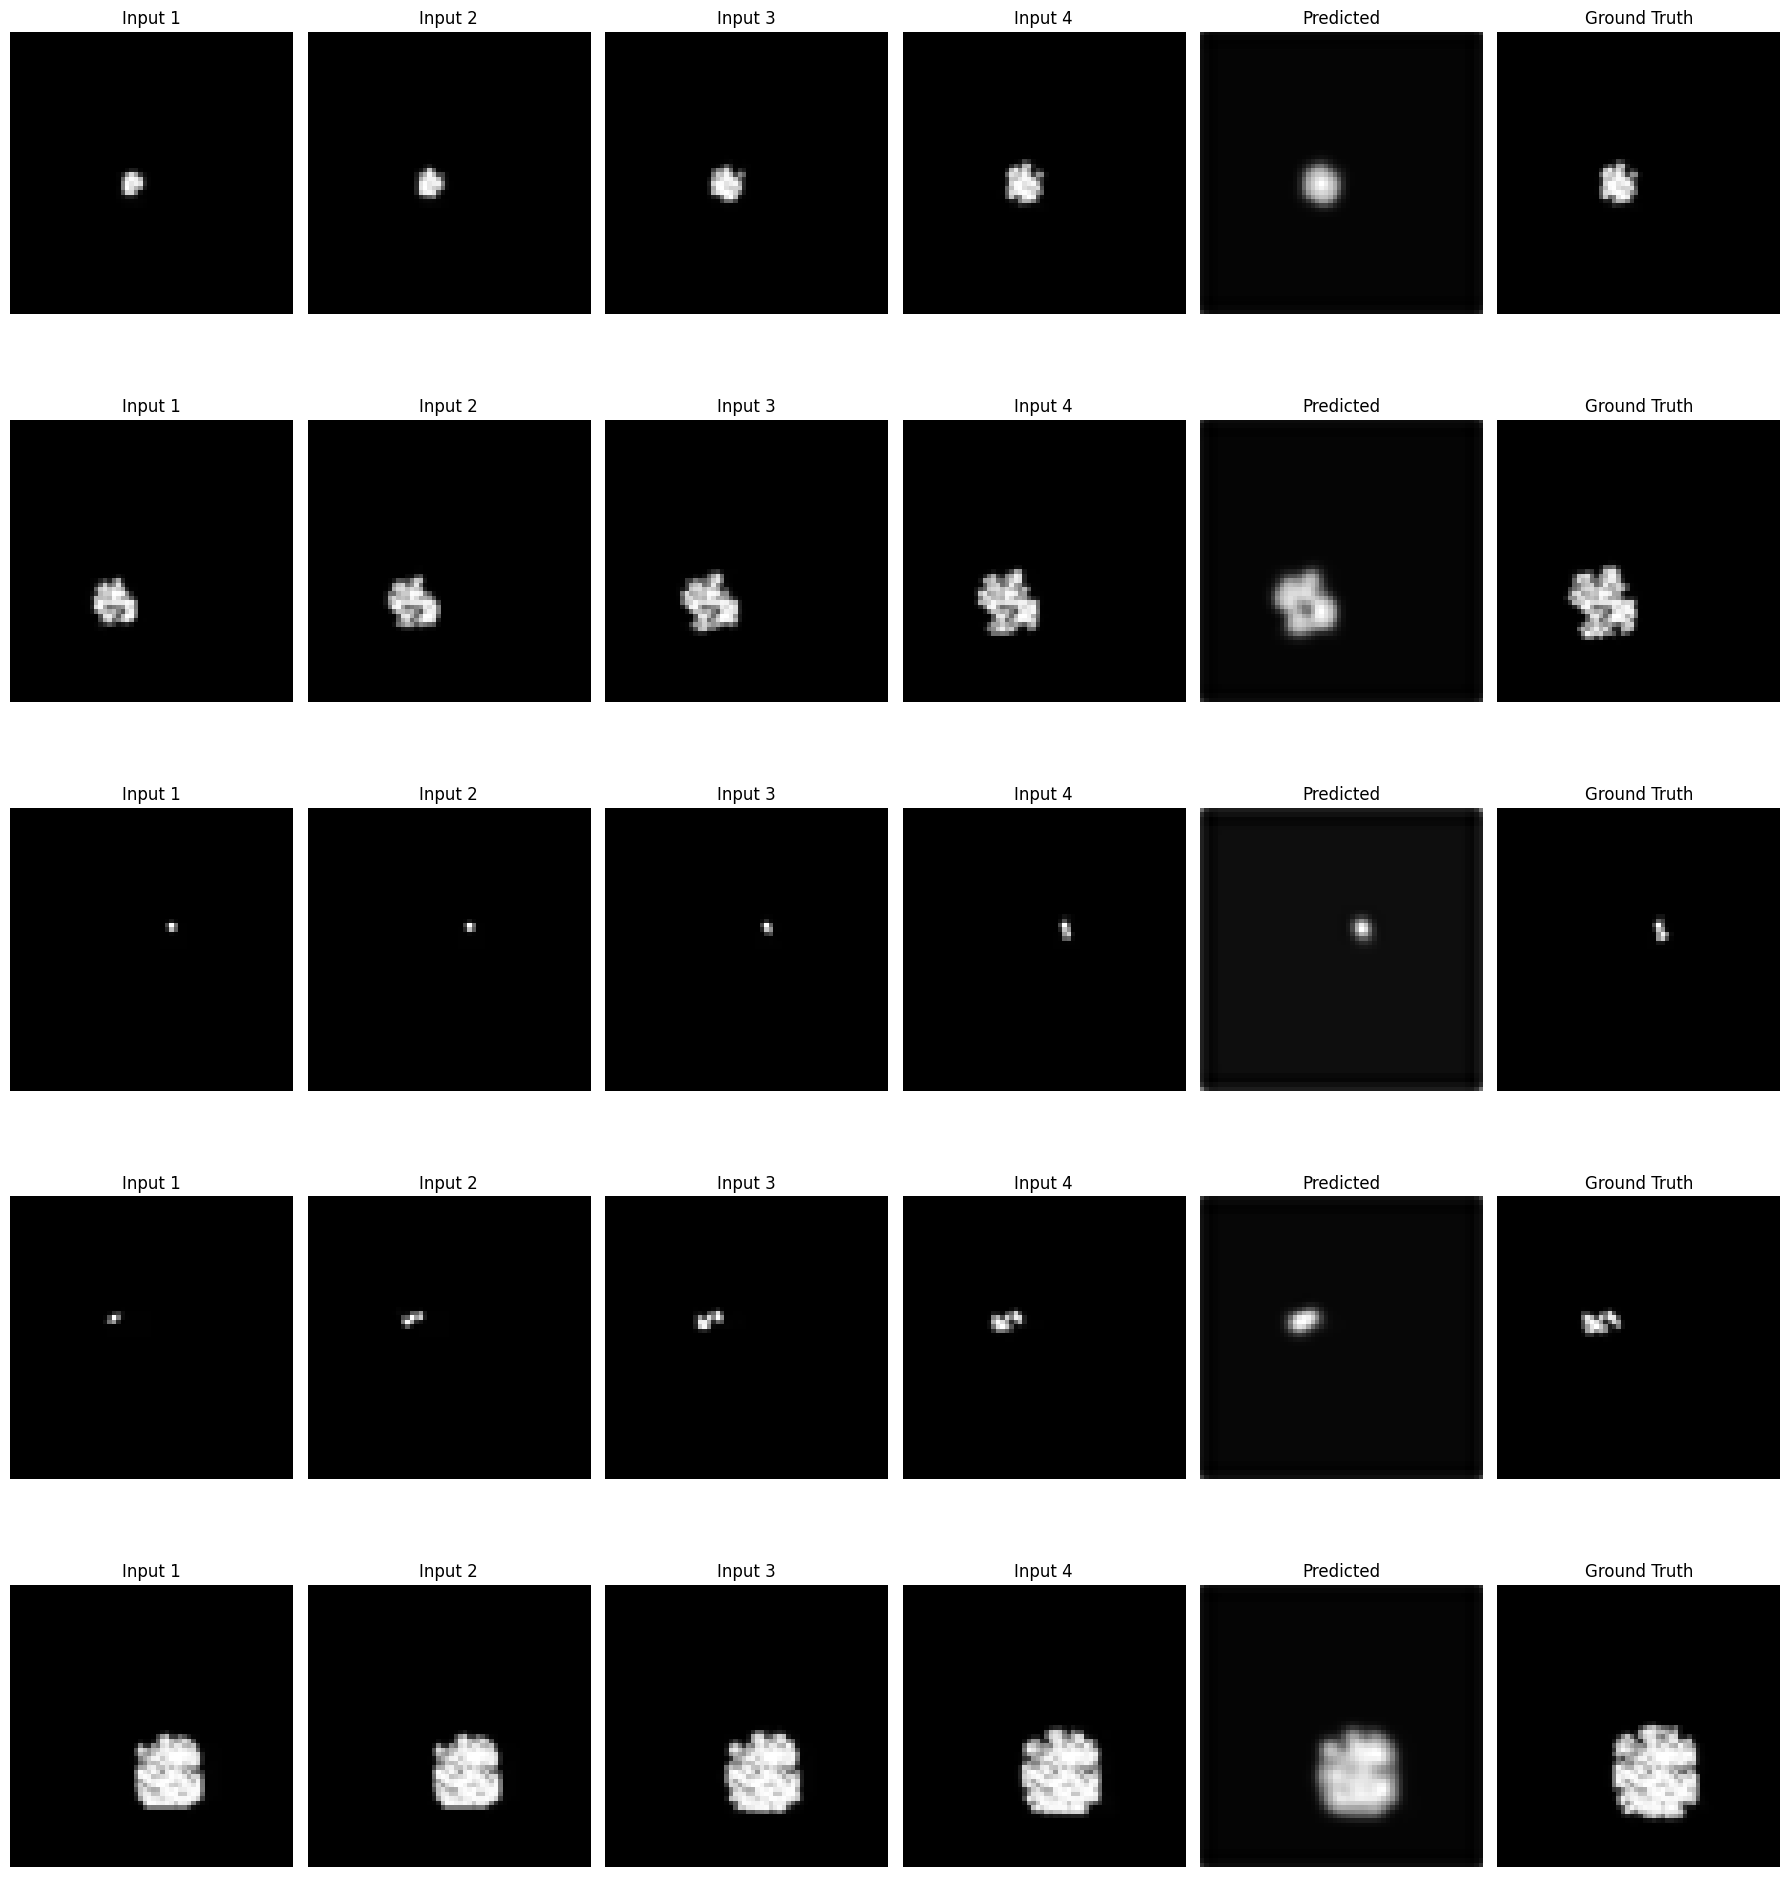

In [36]:
def plot_predictions(predictions, ground_truths, inputs, num_images=5, save=False):
    fig, axs = plt.subplots(num_images, 6, figsize=(18, 20))
    for i in range(num_images):
        # Plot the 4 input images
        for j in range(4):
            input_img = inputs[i, j].squeeze(0)
            axs[i, j].imshow(input_img, cmap='gray')
            axs[i, j].set_title(f'Input {j+1}')
            axs[i, j].axis('off')

        # Plot the predicted image
        pred_img = predictions[i].squeeze(0)
        axs[i, 4].imshow(pred_img, cmap='gray')
        axs[i, 4].set_title('Predicted')
        axs[i, 4].axis('off')

        # Plot the ground truth image
        true_img = ground_truths[i].squeeze(0)
        axs[i, 5].imshow(true_img, cmap='gray')
        axs[i, 5].set_title('Ground Truth')
        axs[i, 5].axis('off')

    plt.tight_layout()
    plt.savefig("lstm_output.png", dpi=300)
    plt.show()

# Example usage with the generate_predictions function
def generate_predictions(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        for cond_images, target_images in test_loader:
            cond_images = cond_images.float().to(device)
            target_images = target_images.float().to(device)
            output = model(cond_images)
            predictions.append(output.cpu())
            ground_truths.append(target_images.cpu())
            inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

preds, ground_truths, inputs = generate_predictions(loaded_model, test_loader)
plot_predictions(preds, ground_truths, inputs, save=True)